# OLI Content Extraction and Analysis

In [1]:
import pandas as pd
import numpy as np
import textract
import re, json, os
from os.path import join
from bs4 import BeautifulSoup
from gensim.summarization import keywords  #must use version 3.8.3 of gensim because gensim.summarization was deprecated in version 4.0.0
import warnings
warnings.filterwarnings("ignore")

c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


## 1. Extract content from PDF file

In [2]:
def extract_content_from_pdf(filename):
    # text variable which contains all the text derived from our PDF file
    full_text = textract.process(filename, method='pdfminer', language='eng').decode('utf-8')
    return full_text.encode('ascii','ignore').lower().decode('utf-8')

def extract_keyword(full_text):
    keyword_summaries = keywords(text = full_text, split = "\n", scores = True)
    data = pd.DataFrame(keyword_summaries, columns = ["keyword", "score"])
    return data.sort_values("score", ascending = False)

## 2. Extract content from XML files 

In [3]:
SEMESTER = "f22"
oli_org = open(f'{SEMESTER}/organizations/default/organization.xml', "r").read()
oli_org_soup = BeautifulSoup(oli_org, "lxml")

In [4]:
def get_module_unit_from_org(page_id):
    try:
        resource_ref = oli_org_soup.find('resourceref', {'idref': page_id})
        curr_module = resource_ref.find_parent('module').find('title').get_text()
        curr_unit = resource_ref.find_parent('unit').find('title').get_text()
        return curr_module, curr_unit
    except:
        return None, None

def is_header(p):
    # a header paragraph should have the form <p><em>...</em></p>, with no other inner tag
    n_contents = len([c for c in p.contents if not str(c.string).isspace()])
    return p.find("em") is not None and n_contents == 1

def get_file_content(filename):
    with open(file = f'{SEMESTER}/content/x-oli-workbook_page/' + filename, encoding='utf-8') as file:
        soup = BeautifulSoup(file.read(), 'lxml', from_encoding='utf-8')
    page_id = soup.find('workbook_page')['id']
    curr_module, curr_unit = get_module_unit_from_org(page_id)
    title = soup.find("title").get_text().strip()   
    
    
    # extract the sub-headers <p><em>text</em></p> and remove them from the text content
    sub_headers = []
    for p in soup.find_all("p"):
        if is_header(p):
            sub_headers.append(p.find("em").get_text().strip())
            p.extract()
    
    all_text = "\n".join(p.get_text().strip() for p in soup.find_all("p")[1:])
    
    all_text = re.sub(r"\n+", r"\n", all_text.strip())
    pattern = r"\\\w+\d+"

    all_text = re.sub(pattern, "", all_text)
    

    return {
        "Unit" : curr_unit, "Module" : curr_module, "Title" : title,
        "Text": all_text, "Subheaders" : ",".join(sub_headers)
    }

In [5]:
import matplotlib.pyplot as plt

In [6]:
df_oli = pd.DataFrame([
    get_file_content(filename)
    for filename in os.listdir(f"{SEMESTER}/content/x-oli-workbook_page")
    if filename.endswith(".xml")
]).dropna()
df_oli.to_csv("f_22_oli_content.csv", index = False, encoding='utf-8')
display(df_oli)

,Unit,Module,Title,Text,Subheaders
0,Deep Learning and Model Deployment,Model Deployment,Quiz 10,,
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,
11,Analytic Algorithms and Model Building,Model Selection,Model Selection for Prediction,To replicate the setting of performing predict...,
12,Data Science Project Planning,Requirements Gathering,Successful Requirements Gathering,The requirements gathering process is not line...,Validating Requirements
13,Exploratory Data Analysis,Feature Engineering,t-SNE,"In the last section, we explored Principal Com...",References:
...,...,...,...,...,...
257,Data Science Project Planning,Requirements Gathering,Types of Requirements,Suppose a utility company wants to introduce p...,"Business Requirements,System and User Requirem..."
258,Deep Learning and Model Deployment,Model Deployment,[Additional Resource] Hands-on: Data Versionin...,AI projects are data intensive. Data can be\np...,Why are traditional code versioning tools inef...
259,Deep Learning and Model Deployment,CPU vs. GPU,Hardware: An Overlooked Aspect of Data Science,At the beginning of a data science process on...,
261,Deep Learning and Model Deployment,CPU vs. GPU,The Basics of Hardware: Memory,"For our purposes, before we get into the diffe...",


Analytic Algorithms and Model Building        31
Deep Learning and Model Deployment            21
Data Science Project Planning                 20
Problem Identification and Solution Vision    18
Name: Unit, dtype: int64

Text(0, 0.5, 'Unit')

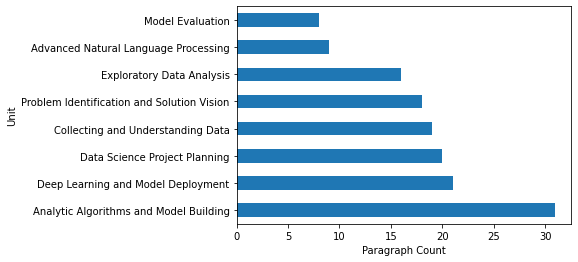

In [8]:
fig, ax = plt.subplots()
display(df_oli['Unit'].value_counts().head())
df_oli['Unit'].value_counts().plot(ax=ax, kind='barh')
ax.axes.set_xlabel('Paragraph Count')
ax.axes.set_ylabel('Unit')


Supervised and Unsupersived Techniques     11
Requirements Gathering                      9
Distilling the Analytic Objective           9
Deep Learning & Computer Vision             9
Text Data & Natural Language Processing     8
Name: Module, dtype: int64

Text(0, 0.5, 'Module')

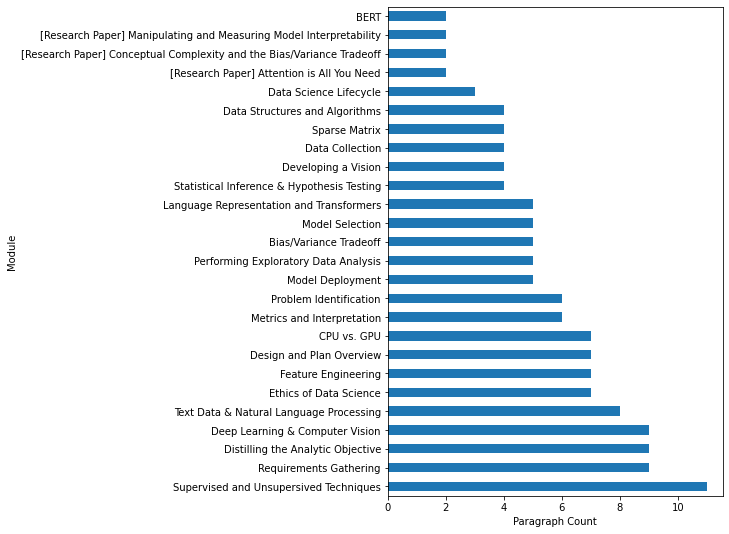

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(6,9)
display(df_oli['Module'].value_counts().head())
df_oli['Module'].value_counts().plot(ax=ax, kind='barh')
ax.axes.set_xlabel('Paragraph Count')
ax.axes.set_ylabel('Module')


## 3. Topic modeling with LDA

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[('data', 1392), ('model', 459), ('used', 258), ('science', 222), ('models', 217), ('project', 214), ('use', 201), ('dataset', 195), ('requirements', 195), ('learning', 192)]


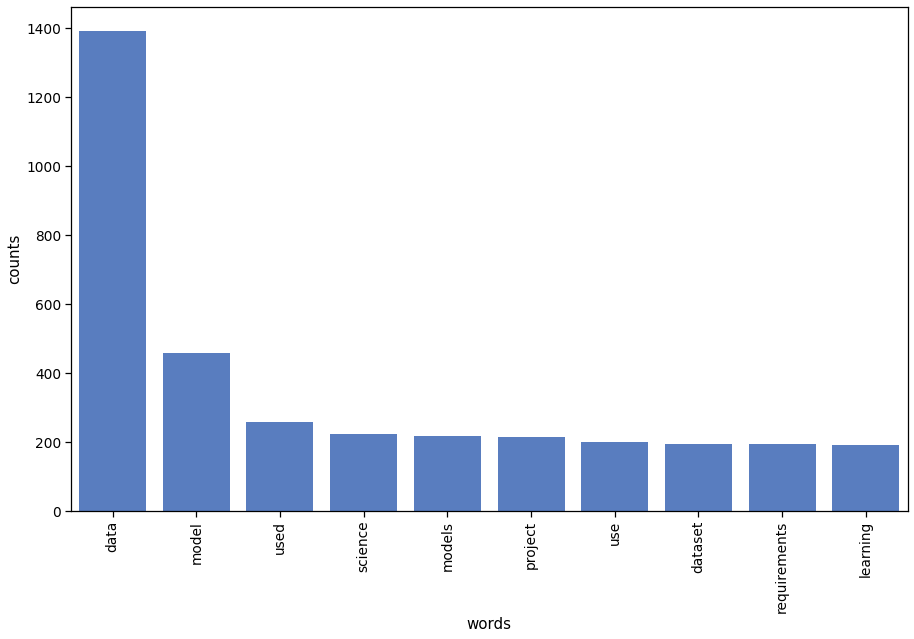

In [13]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    # get the count of each word across the entire corpus
    total_counts = count_data.sum(axis = 0).A.ravel()

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words, counts = zip(*count_dict)
    print(count_dict)
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    #plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.set_color_codes("muted")
    sns.barplot(x=x_pos, y=list(counts), color='b')
    plt.xticks(x_pos, list(words), rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Preprocess the text to prepare for LDA
df_oli["Cleaned Text"] = df_oli["Text"].apply(lambda text: re.sub('[,\.!?]', '', text).lower())
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_oli['Cleaned Text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## 4. QA generation with pretrained huggingface model


In [23]:
from pipelines import pipeline
question_generator = pipeline("e2e-qg");

ModuleNotFoundError: No module named 'pipelines'

In [133]:
def generate_question_by_paragraph(df):
    df["Paragraph"] = df["Text"].str.split("\n")
    df_para = df.explode("Paragraph")
    df_para["Generated Question"] = df_para["Paragraph"].apply(question_generator)
    return df_para.explode("Generated Question")

In [134]:
df_oli_with_questions = generate_question_by_paragraph(df_oli)

In [135]:
df_oli_with_questions = df_oli_with_questions[df_oli_with_questions['Text']!= '']

In [136]:
df_oli_with_questions.drop(columns = "Text").to_csv("f22_oli_content_with_questions.csv", index = False)

In [137]:
df_oli_with_questions.reset_index()

,index,Unit,Module,Title,Text,Subheaders,Cleaned Text,Paragraph,Generated Question
0,6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,What module focuses on the foundation of a doc...
1,6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,What document provides a summary of the project?
2,6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,How does this document clear up confusion?
3,6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,The project's high-level scope and purpose are...,In what document is the project's scope and pu...
4,6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,The project's high-level scope and purpose are...,What is the purpose of the project?
...,...,...,...,...,...,...,...,...,...
4089,262,Problem Identification and Solution Vision,Problem Identification,"AI Philosophy: A Process, not a Product","AI Philosophy: A Process, not a Product\nAI Ph...",,ai philosophy: a process not a product\nai phi...,AI Ready. The organization has determined how ...,What does AI Ready mean?
4090,262,Problem Identification and Solution Vision,Problem Identification,"AI Philosophy: A Process, not a Product","AI Philosophy: A Process, not a Product\nAI Ph...",,ai philosophy: a process not a product\nai phi...,AI Ready. The organization has determined how ...,How can AI help end-users?
4091,262,Problem Identification and Solution Vision,Problem Identification,"AI Philosophy: A Process, not a Product","AI Philosophy: A Process, not a Product\nAI Ph...",,ai philosophy: a process not a product\nai phi...,AI Enabled. The organization has deployed the ...,What is an organization able to measure the im...
4092,262,Problem Identification and Solution Vision,Problem Identification,"AI Philosophy: A Process, not a Product","AI Philosophy: A Process, not a Product\nAI Ph...",,ai philosophy: a process not a product\nai phi...,AI Enabled. The organization has deployed the ...,What can an organization claim that it has imp...


In [138]:
display(df_oli_with_questions.head())

,Unit,Module,Title,Text,Subheaders,Cleaned Text,Paragraph,Generated Question
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,What module focuses on the foundation of a doc...
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,What document provides a summary of the project?
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,This module focuses on the foundation of a doc...,How does this document clear up confusion?
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,The project's high-level scope and purpose are...,In what document is the project's scope and pu...
6,Data Science Project Planning,Developing a Vision,Module 4 Summary,This module focuses on the foundation of a doc...,,this module focuses on the foundation of a doc...,The project's high-level scope and purpose are...,What is the purpose of the project?


In [139]:
df_oli_with_questions.reset_index().iloc[2026, [-2, -1]].tolist()

['The goodness of fit of a model will show how the model fits the data that it is trained with, and it will highlight any lack of balance between observations in the dataset and those that will be introduced to the model (new values). To select the right method, one can use the different metrics below:',
 'What will highlight a lack of balance between observations in the dataset and those that will be introduced to the model?']